In [1]:
%matplotlib inline

import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt

import sys
sys.path.append('../code')
sys.path.append('../code/opt')
import gpr as gp
import kernel as ks
import adam

from scipy.spatial.distance import cdist

In [2]:
run ../code/tests/kerneltest.py

In [3]:
kern = ks.LocalPeriodic(np.array([1., 3., 0.4, 0.4]))

In [4]:
testKernelGrad(kern)[0]

[True, True, True, True]

In [5]:
x_obs = np.arange(-3,3,0.5)
x_obs += np.random.randn(len(x_obs))*0.05
x_obs = np.sort(x_obs)
noise = 0.4

K = kern(x_obs, x_obs) + noise**2*np.eye(x_obs.shape[0])
y_obs = np.random.multivariate_normal(np.zeros_like(x_obs), K)

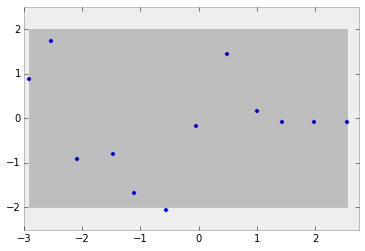

In [6]:
plt.scatter(x_obs, y_obs)
plt.fill_between(x_obs, -2, 2, color='k', alpha=0.2,);
plt.xlim([-3, 3-0.25]); plt.ylim([-2.5, 2.5]);

In [7]:
mygpr = gp.GPR(kern)

In [8]:
x_test = np.linspace(-3,3,50)
mean, var = mygpr.fit_transform(y_obs, x_obs, noise**2, x_test)

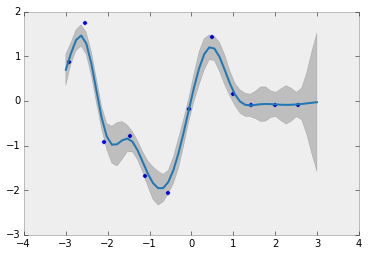

In [9]:
plt.plot(x_test, mean)
plt.scatter(x_obs, y_obs)
plt.fill_between(x_test, mean-2*var.diagonal(), mean+2*var.diagonal(), alpha=0.2, color='k')

In [16]:
opt = adam.Adam(mygpr.log_gradmarg, mygpr.kernel.N_p+1)

In [23]:
opt.optimize(np.r_[mygpr.kernel.p, noise**2]+np.random.randn(5)*0.4, tol=0.001)

LinAlgError: 1-th leading minor not positive definite

In [22]:
mygpr.log_gradmarg(np.r_[mygpr.kernel.p, noise**2])

(24.161366542865636,
 array([ -9.27146693,   0.98464974,   7.02395118,   6.01042274, -60.35507932]))